<a href="https://colab.research.google.com/github/lmcanavals/experiments/blob/main/notebooks/ab_statistical_expeimentation_anova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentos Estadísticos y Prueba de Significancia

In [1]:
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
BASE="https://raw.githubusercontent.com/lmcanavals/practical-statistics-for-data-scientists/master/data/"
WEB_PAGE_DATA_CSV   = f"{BASE}web_page_data.csv"
FOUR_SESSION_CSV    = f"{BASE}four_sessions.csv"
CLICK_RATE_CSV      = f"{BASE}click_rates.csv"
IMANISHI_CSV        = f"{BASE}imanishi_data.csv"

## Muestreo

In [4]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


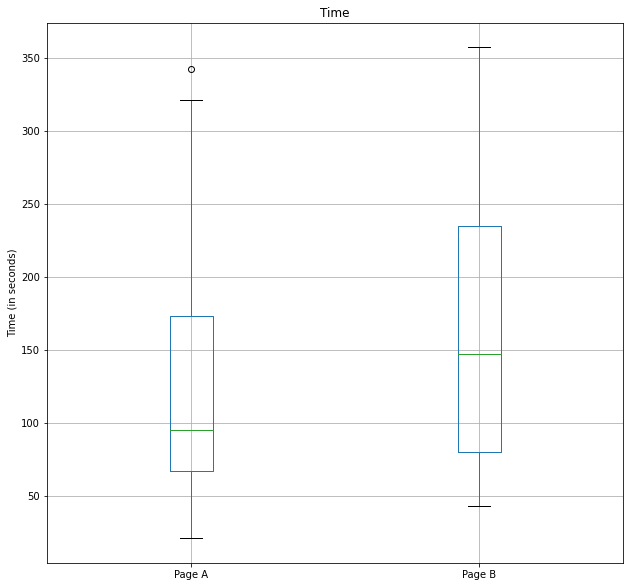

In [15]:
ax = session_times.boxplot(by="Page", column="Time", figsize=(10, 10))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.show()

In [7]:
mean_a = session_times[session_times['Page'] == 'Page A']['Time'].mean()
mean_b = session_times[session_times['Page'] == 'Page B']['Time'].mean()
print(mean_b - mean_a)

35.66666666666667


In [14]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = session_times[session_times['Page'] == 'Page A']['Time'].shape[0]
nB = session_times[session_times['Page'] == 'Page B']['Time'].shape[0]
print(perm_fun(session_times['Time'], nA, nB))

6.523809523809518


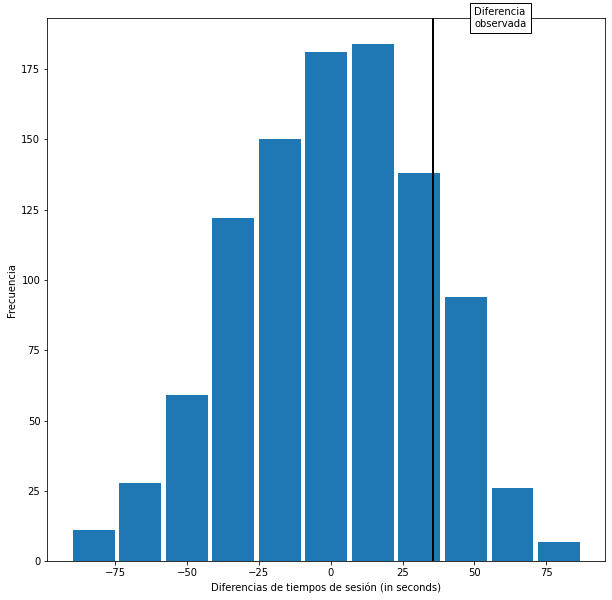

In [20]:
random.seed(1981)
perm_diffs = [perm_fun(session_times['Time'], nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(50, 190, 'Diferencia\nobservada', bbox={'facecolor':'white'})
ax.set_xlabel('Diferencias de tiempos de sesión (in seconds)')
ax.set_ylabel('Frecuencia')

plt.show()

## Significancia Estadística y P-values

Outcome | Price A | Price B
-|-|-
Conversion| 200 | 182
No Conversion | 23539 | 22406

Diferencia observada: 0.0368


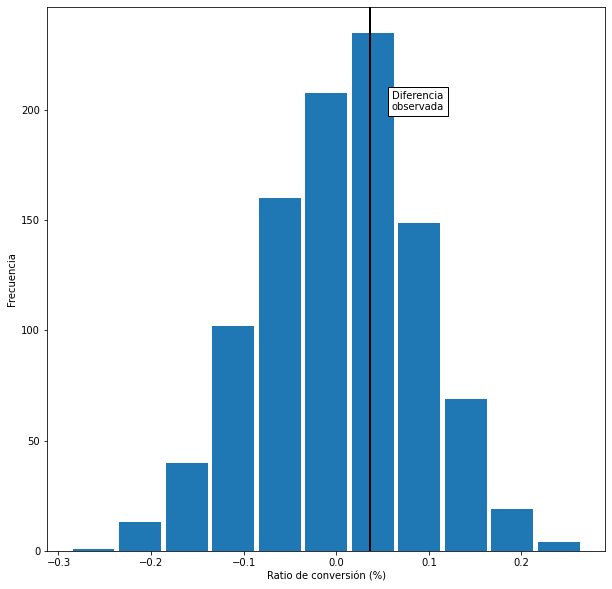

In [24]:
random.seed(1981)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f"Diferencia observada: {obs_pct_diff:.4f}")
conversion = [0]*45945
conversion.extend([1]*382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Diferencia\nobservada', bbox={'facecolor':'white'})
ax.set_xlabel('Ratio de conversión (%)')
ax.set_ylabel('Frecuencia')

plt.show()

### P-Value

In [25]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.358


In [26]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"p_value para una prueba de un solo lado: {p_value / 2:.4f}")

p_value para una prueba de un solo lado: 0.3498


Asumiendo un alpha de 5%, como nuestro resultado tuvo un P-value de 34.98%, podemos decir que es estadisticamente significativo.

## t-Test

In [27]:
res = stats.ttest_ind(session_times[session_times['Page'] == 'Page A']['Time'],
                      session_times[session_times['Page'] == 'Page B']['Time'],
                      equal_var=False)
print(f"p-value: {res.pvalue / 2:0.4f}")

p-value: 0.1408


In [29]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times['Page'] == 'Page A']['Time'],
    session_times[session_times['Page'] == 'Page B']['Time'],
    usevar='unequal', alternative='smaller')
print(f"p-value: {pvalue:0.4f}")

p-value: 0.1408


## ANOVA

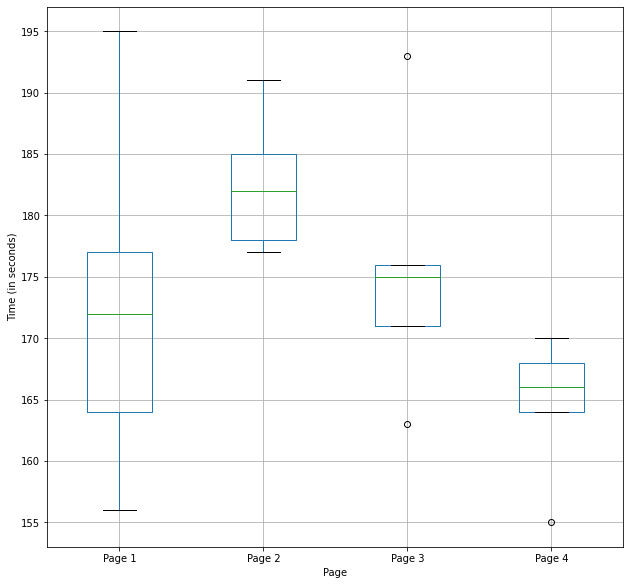

In [30]:
four_sessions = pd.read_csv(FOUR_SESSION_CSV)

ax = four_sessions.boxplot(by='Page', column='Time', figsize=(10, 10))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.show()